In [1]:
import argparse
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct


from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers import LeakyReLU,AvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
session = K.tf.Session(config=config)
K.set_session(session)

import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes

Using TensorFlow backend.


In [2]:
ANCHORS  = [[0.36,0.17,  0.67,0.24, 0.18,0.105], [0.65,0.16, 0.197,0.06, 0.39,0.076],[0.18,0.02, 0.35,0.026, 0.56,0.03]]

LABELS = ['tableRegion', 'figureRegion', 'formulaRegion']
GRID_H,  GRID_W  = 15, 15
IMAGE_H, IMAGE_W = GRID_H*64,  GRID_W*64


ANCHORS = np.asarray(ANCHORS,dtype=np.float32)*np.asarray([[GRID_H], [GRID_H*2], [GRID_H*4]])
BOX              = 3
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.6#0.5
NMS_THRESHOLD    = 0.3#0.45

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 8
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [3]:
weights_path = '../experimental/yolov3.weights'                      
train_image_folder = '/home/zhuleike/data/science/Train/JPEGImages/'
train_annot_folder = '/home/zhuleike/data/science/Train/Annotations/'
test_image_folder = '/home/zhuleike/data/science/Test/JPEGImages/'
test_annot_folder = '/home/zhuleike/data/science/Test/annotations/'
#valid_annot_folder = '/home/trunk/RTrunk0/zhuleike/data/VOCdevkit/VOC2012/Annotations/valid/'


In [4]:


class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    i = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        

        x = Conv2D(conv['filter'], 
                   kernel_size = conv['kernel'], 
                   strides=conv['stride'], 
                   padding='same', 
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    
    for i in range(7):
        if i % 2 == 0:
            tempkernel = (5,1)
        else:
            tempkernel = (1,5)
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': tempkernel, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        if i % 2 == 0:
            tempkernel = (5,1)
        else:
            tempkernel = (1,5)
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': tempkernel, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': (1,5), 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        if i % 2 == 0:
            tempkernel = (5,1)
        else:
            tempkernel = (1,5)
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': tempkernel, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': (1,5), 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': (5,1), 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  3*(5 + CLASS), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': (1,5), 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': (5,1), 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 3*(5 + CLASS), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': (1,5), 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': (5,1), 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 3*(5 + CLASS), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    yolo_82 =  Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(yolo_82)
    yolo_94 =  Reshape((GRID_H*2, GRID_W*2, BOX, 4 + 1 + CLASS))(yolo_94)
    yolo_106 =  Reshape((GRID_H*4, GRID_W*4, BOX, 4 + 1 + CLASS))(yolo_106)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model



model = make_yolov3_model()
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            if i  in [81, 93, 105]:
                continue
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                if conv_layer.kernel.shape[0] == conv_layer.kernel.shape[1] :
                    print("loading weights of convolution #" + str(i))

                    if i not in [81, 93, 105]:
                        norm_layer = model.get_layer('bnorm_' + str(i))

                        size = np.prod(norm_layer.get_weights()[0].shape)

                        beta  = self.read_bytes(size) # bias
                        gamma = self.read_bytes(size) # scale
                        mean  = self.read_bytes(size) # mean
                        var   = self.read_bytes(size) # variance            

                        weights = norm_layer.set_weights([gamma, beta, mean, var])  

                    if len(conv_layer.get_weights()) > 1:
                        bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                        kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))

                        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                        kernel = kernel.transpose([2,3,1,0])
                        conv_layer.set_weights([kernel, bias])
                    else:
                        kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                        kernel = kernel.transpose([2,3,1,0])
                        conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0
weight_reader = WeightReader(weights_path)
weight_reader.load_weights(model)

##### 

In [5]:
model = make_yolov3_model()


In [6]:
model.load_weights('current_best2.h5')

In [9]:
#model.load_weights("weights_coconew.h5")

def single_loss(anchor_index):
    def custom_loss(y_true, y_pred):
        # only caculate the y_true[...,4] > -0.5
        
        caculate_index = y_true[...,4] + 2
        true_box_conf = tf.clip_by_value(y_true[...,4],0,1)
        #GRID_W , GRID_H = mask_shape[1], mask_shape[2]
        scale_anchor = 2**anchor_index


        """
        Adjust prediction
        """
        ### adjust x and y    
        
        pred_box_xy = tf.sigmoid(y_pred[..., :2])
        ### adjust w and h
        pred_box_wh = tf.exp(y_pred[..., 2:4])*np.reshape(ANCHORS[anchor_index], [1,1,1,BOX,2])
                              

        ### adjust confidence
        pred_box_conf = tf.sigmoid(y_pred[..., 4])
                              

        ### adjust class probabilities
        #pred_box_class = y_pred[..., 5:]
        pred_box_class = tf.sigmoid(y_pred[..., 5:] )
                              

        """
        Adjust ground truth
        """
        ### adjust x and y
        center_xy = y_true[..., :2] 
        true_box_xy = center_xy# - tf.floor(center_xy)# relative position to the containing cell
                              

        ### adjust w and h
        true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
                              
        ### adjust confidence

        #true_box_conf = iou_scores * y_true[..., 4]

        ### adjust class probabilities
        true_box_class = tf.argmax(y_true[..., 5:], -1)
                              
        true_box_classfy = y_true[..., 5:]

        """
        Determine the masks
        """
        ### coordinate mask: simply the position of the ground truth boxes (the predictors)
        coord_mask = true_box_conf#y_true[..., 4]#tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE

        ### confidence mask: penelize predictors + penalize boxes with low IOU

        # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
        #conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE + (1 - y_true[..., 4]) * NO_OBJECT_SCALE

        #conf_mask = true_box_conf * OBJECT_SCALE + (1 - true_box_conf) * NO_OBJECT_SCALE
        ### class mask: simply the position of the ground truth boxes (the predictors)
        class_mask = true_box_conf * CLASS_SCALE       

        """
        Warm-up training
        """


                              

        """
        Finalize the loss
        """

        
        # 按置信系数给长框设置权重
        maxconf = tf.reduce_max(pred_box_conf, axis = 3 ,keepdims=True) - 0.1
        
        loss_conf = tf.nn.relu(pred_box_conf - maxconf)#+ tf.to_float(pred_box_conf > maxconf - 1e-4)*1e-6
        whscale = loss_conf/tf.reduce_sum(loss_conf,axis = 3,keepdims=True ) 
        whscale = tf.expand_dims(whscale, 4)
        pred_box_wh = tf.reduce_sum(pred_box_wh*whscale, axis = 3,keepdims=True)
        pred_box_xy = tf.reduce_sum(pred_box_xy*whscale, axis = 3,keepdims=True)
        
        # 更改了这两个所属的位置
                           
        caculate_index = caculate_index + 0.2*tf.reduce_max(caculate_index,axis=[1,2,3], keepdims=True)*pred_box_conf*tf.to_float(y_true[...,4] > - 0.5)
        caculate_index_num = tf.reduce_sum(caculate_index) + 1e-6    
        
        
        scalewh  =    tf.to_float(true_box_wh > 1e-6)/( true_box_wh + 1e-6)
        loss_xy    = tf.reduce_sum(tf.nn.relu(tf.abs(true_box_xy-pred_box_xy)*scalewh*2 - 0.1), axis=-1 ) * coord_mask#/ (nb_coord_box + 1e-6) / 2.
        loss_wh    = tf.reduce_sum(tf.nn.relu(tf.abs(true_box_wh - pred_box_wh)*scalewh - 0.1), axis=-1 )  * coord_mask#/ (nb_coord_box + 1e-6) / 2.
     
        #loss_xy    = tf.reduce_sum(tf.nn.relu(tf.abs(true_box_xy-pred_box_xy) - tf.clip_by_value(0.02*true_box_wh , 0.01,1)), axis=-1 ) * coord_mask#/ (nb_coord_box + 1e-6) / 2.
        #loss_wh    = tf.reduce_sum(tf.nn.relu(tf.abs(tf.sqrt(true_box_wh)-tf.sqrt(pred_box_wh)) - 0.1), axis=-1 )  * coord_mask#/ (nb_coord_box + 1e-6) / 2.
        loss_conf  = tf.nn.relu(tf.abs(tf.reduce_sum(true_box_conf,axis=3,keepdims=True) - tf.reduce_sum(pred_box_conf,axis=3,keepdims=True)) - 0.3) *caculate_index#  / (nb_conf_box  + 1e-6) / 2.
        
        # 非目标领域误检的加大惩罚系数
        loss_class = tf.reduce_sum(tf.nn.relu(tf.abs(true_box_classfy - pred_box_class) - 0.1 ), axis=-1 )*class_mask
        
        coord_mask_num =  tf.reduce_sum(coord_mask) + 1e-6
        class_mask_num = tf.reduce_sum(class_mask) + 1e-6
        
        loss = (loss_xy + loss_wh  + loss_class)/coord_mask_num + loss_conf/caculate_index_num
        
        loss = tf.reduce_sum(loss)
        
        '''
        loss_xy = tf.reduce_sum(loss_xy)/coord_mask_num 
        loss_wh = tf.reduce_sum(loss_wh)/coord_mask_num 
        loss_conf = tf.reduce_sum(loss_conf)/caculate_index_num
        loss_class = tf.reduce_sum(loss_class)/class_mask_num
        loss = loss_xy + loss_wh + loss_conf + loss_class# + loss_coor_conf
        '''

        return loss
    return custom_loss

In [10]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [11]:
def normalize(image):
    return image / 255.

In [12]:
#from preprocessing import parse_annotation

In [23]:
train_imgs = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
#valid_imgs, seen_train_labels = parse_annotation(valid_annot_folder, train_image_folder, labels=LABELS)
valid_imgs = train_imgs[::2]
#train_imgs = train_imgs[1::2]

train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

In [14]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('yolov3_18.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [15]:


optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0,clipvalue=1)

model.compile(loss=[single_loss(0),single_loss(1), single_loss(2)], optimizer=optimizer)

for i in range(1):

    history = model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [checkpoint,early_stop], 
                    max_queue_size   = 3)

Epoch 1/100
100/100 [==============================] - 139s 1s/step - loss: 0.0631 - reshape_1_loss: 0.0173 - reshape_2_loss: 0.0346 - reshape_3_loss: 0.0112 - val_loss: 0.0627 - val_reshape_1_loss: 0.0118 - val_reshape_2_loss: 0.0304 - val_reshape_3_loss: 0.0205

Epoch 00001: val_loss improved from inf to 0.06268, saving model to yolov3_18.h5
Epoch 2/100
100/100 [==============================] - 118s 1s/step - loss: 0.0747 - reshape_1_loss: 0.0192 - reshape_2_loss: 0.0444 - reshape_3_loss: 0.0111 - val_loss: 0.0520 - val_reshape_1_loss: 0.0120 - val_reshape_2_loss: 0.0296 - val_reshape_3_loss: 0.0105

Epoch 00002: val_loss improved from 0.06268 to 0.05204, saving model to yolov3_18.h5
Epoch 3/100
100/100 [==============================] - 115s 1s/step - loss: 0.0684 - reshape_1_loss: 0.0140 - reshape_2_loss: 0.0453 - reshape_3_loss: 0.0091 - val_loss: 0.0601 - val_reshape_1_loss: 0.0165 - val_reshape_2_loss: 0.0271 - val_reshape_3_loss: 0.0165

Epoch 00003: val_loss did not improve f

In [24]:
for i in range(2):
    print("Iteration:{}".format(i))

    model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint], 
                    max_queue_size   = 3)

Iteration:0
Epoch 1/100
200/200 [==============================] - 184s 920ms/step - loss: 0.0691 - reshape_1_loss: 0.0129 - reshape_2_loss: 0.0415 - reshape_3_loss: 0.0147 - val_loss: 0.0762 - val_reshape_1_loss: 0.0227 - val_reshape_2_loss: 0.0304 - val_reshape_3_loss: 0.0231

Epoch 00001: val_loss did not improve from 0.04224
Epoch 2/100
200/200 [==============================] - 184s 920ms/step - loss: 0.0713 - reshape_1_loss: 0.0259 - reshape_2_loss: 0.0354 - reshape_3_loss: 0.0100 - val_loss: 0.0801 - val_reshape_1_loss: 0.0258 - val_reshape_2_loss: 0.0331 - val_reshape_3_loss: 0.0213

Epoch 00002: val_loss did not improve from 0.04224
Epoch 3/100
200/200 [==============================] - 184s 919ms/step - loss: 0.0577 - reshape_1_loss: 0.0154 - reshape_2_loss: 0.0311 - reshape_3_loss: 0.0112 - val_loss: 0.0446 - val_reshape_1_loss: 0.0129 - val_reshape_2_loss: 0.0197 - val_reshape_3_loss: 0.0120

Epoch 00003: val_loss did not improve from 0.04224
Epoch 4/100
200/200 [==========

In [29]:
model.save_weights('yolov3_18.h5')

In [10]:
test_image_folder = '/home/zhuleike/data/science/Test/JPEGImages/'

In [11]:
#from utils import decode_netout2
#filename = 'utils.py'
#exec(compile(open(filename, "rb").read(), filename, 'exec'))
current_test = train_batch

for number in range(20):

    plt.figure(figsize=(10,10))
    imagepath = current_test[number]['filename']
    objects = current_test[number]['object']

    #plt.figure(figsize=(10,10))
    image = cv2.imread(imagepath)
    h, w, c = image.shape
  
    input_image = cv2.resize(image, (IMAGE_W, IMAGE_H))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict(input_image)
    boxes = decode_netout(netout, 
                          obj_threshold=OBJ_THRESHOLD,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)    
    fontsize = 3
    for box in boxes:
        x1, y1, x2, y2,new_probs  = box.xmin, box.ymin, box.xmax, box.ymax, box.c
        key = LABELS[box.get_label()]
        xmin, ymin, xmax, ymax = int(x1*w),int(y1*h), int(x2*w), int(y2*h)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        (retval,baseLine) = cv2.getTextSize(key,1,1,1)
        cv2.rectangle(image, (xmin - fontsize *5 , ymin+baseLine*fontsize -15), (xmin , ymin-retval[1]*fontsize  - 15), (0, 0, 0), 3)
        cv2.rectangle(image, (xmin - fontsize *5,ymin+baseLine*fontsize  -15), (xmin+retval[0]*fontsize , ymin -retval[1]*fontsize  - 15), (0, 225, 0), -1)
        cv2.putText(image, key, (xmin  , ymin - 10), fontsize , 1, (0, 0, 225), 3)   

        
    for obj in objects:
        xmin, ymin, xmax, ymax =  obj['xmin'],obj['ymin'],obj['xmax'],obj['ymax']
        cv2.rectangle(image, (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (0,255,0), 2)
        (retval,baseLine) = cv2.getTextSize(obj['name'],1,1,1)
        cv2.rectangle(image, (xmax - fontsize *5 , ymin+baseLine*fontsize -15), (xmax , ymin-retval[1]*fontsize  - 15), (0, 0, 0), 3)
        cv2.rectangle(image, (xmax - fontsize *5,ymin+baseLine*fontsize  -15), (xmax+retval[0]*fontsize , ymin -retval[1]*fontsize  - 15), (0, 0, 255), -1)
        cv2.putText(image, obj['name'], (xmax  , ymin - 10), fontsize , 1, (0, 255, 0), 3)   

    plt.imshow(image); plt.show()


NameError: name 'train_batch' is not defined

In [12]:
filename = 'preprocessing.py'
exec(compile(open(filename, "rb").read(), filename, 'exec'))

In [18]:
imagehw = []
mistake = []
for img in all_imgs:
    txtfilename = '/home/zhuleike/data/science/Train/gt_formula/gt_' + img['filename'].split('/')[-1][:-4] + '.txt'
    fo = open(txtfilename,"w")
    
    for obj in img['object']:     
        if obj['name'] == 'formulaRegion':
            x1,x2,y1,y2 = obj['xmin'], obj['xmax'], obj['ymin'], obj['ymax'],
            coord = str(x1)+','+str(y1)+','+str(x2)+','+str(y1)+','+ str(x2)+','+str(y2)+','+ str(x1)+','+str(y2)+',formulaRegion'
            fo.write(coord + '\n')
    fo.close()
        
    

In [16]:
def build_model():
    # 构建卷积神经网络结构
    input_image = Input(shape = (32, 960,3))
    x = Conv2D(32, (3, 3), strides=(1,1), use_bias =False)(input_image)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 4))(x)
    x = Conv2D(64, (3, 3), strides=(1,1), use_bias =False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 4))(x)
    for i in range(0,3):
        channel = min(512, 128*(2**i))
        x = Conv2D(channel*2, (1, 1), use_bias =False, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)        
        x = Conv2D(channel, (2, 4), strides=(1,1), use_bias =False, padding='valid')(x) 
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = LeakyReLU(alpha=0.1)(x)

        
    x = Conv2D(channel, (2, 4), strides=(1,1), use_bias =False, name = 'end1')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(128, (2, 1), strides=(1,1), use_bias =False, name = 'end2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)    
    x = Conv2D(2, (1, 1), use_bias =False,activation='sigmoid', name = 'endl3')(x)

    model = Model(inputs=input_image, outputs=x)
    return model

#formula_model = build_model()
formula_model = build_model()
formula_model.load_weights('/home/zhuleike/workspace/bishe/muticlassfy/rotatnew.hdf5')

In [17]:
from utils import decode_netout2


def build_model():
    # 构建卷积神经网络结构
    input_image = Input(shape = (32, 960,3))
    x = Conv2D(32, (3, 3), strides=(2,2), use_bias =False)(input_image)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), strides=(1,1), use_bias =False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    for i in range(0,4):
        channel = min(512, 128*(2**i))
        x = Conv2D(channel, (1, 3), strides=(1,2), use_bias =False, padding='valid')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(channel, (2, 2), strides=(1,1), use_bias =False, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)

    x =  Conv2D(channel, (2, 3), strides=(2,2), use_bias =False, name = 'end1')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(128, (1, 2), strides=(1,1), use_bias =False, name = 'end2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)    
    x = Conv2D(2, (1, 1), use_bias =False,activation='sigmoid', name = 'endl3')(x)

    model = Model(inputs=input_image, outputs=x)
    return model
#formula_model = build_model()
formula_model = build_model()
formula_model.load_weights('/home/zhuleike/workspace/bishe/muticlassfy/rotatemore.hdf5')

In [18]:
def judge_image_col(image):
    h,w,_ = image.shape
    image = image[h//4: h//4*3]
    a = np.sum(np.max(image)-image, 0)
    a = np.max(a,-1)
    lena = len(a)
    down = int(450.0/1100*lena)
    uppe = int(600.0/1100*lena)

    middle = np.where(a[down:uppe] < np.mean(a)*0.1)[0]

    if len(middle) == 0:
        return 0
    else:
        return int(np.mean(middle)+down)

In [27]:
filename = 'utils.py'
exec(compile(open(filename, "rb").read(), filename, 'exec'))
import time
import xml
OBJ_THRESHOLD    = 0.11
NMS_THRESHOLD    = 0.4
start_time = time.time()
doc = xml.dom.minidom.Document() 
#在内存中创建一个空的文档
offyy = 5
root = doc.createElement('root') 
def writeimage(imagename):
    singleimage = doc.createElement('document') 
    singleimage.setAttribute('filename', imagename) 
    return singleimage  
# generate the probs and coords for boxes
def write2xml(boxname,  prob, coord):


    nodeManager = doc.createElement(boxname)
    nodeManager.setAttribute('prob', prob)
    nodeName = doc.createElement('Coords')
    nodeName.setAttribute('points', coord)

    nodeManager.appendChild(nodeName)
    return nodeManager

for idx, img_name in enumerate(sorted(os.listdir(test_image_folder))):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    singleimage = writeimage(img_name)
    imagepath = os.path.join(test_image_folder,img_name)

    #plt.figure(figsize=(10,10))
    image = cv2.imread(imagepath)
    col_index = judge_image_col(image)
    if col_index!= 0:
        image_l = image[:,:col_index]/255.0
        image_r = image[:,col_index:]/255.0
    h,w,_ = image.shape
    
    
    input_image = cv2.resize(image, (IMAGE_H, IMAGE_W))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]

    
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict(input_image)
    boxes = decode_netout2(netout, 
                          obj_threshold=OBJ_THRESHOLD,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)    
    for box in boxes:
        x1, y1, x2, y2,new_probs  = box.xmin, box.ymin, box.xmax, box.ymax, box.c
        
        key = LABELS[box.get_label()]
        x1, y1, x2, y2 = int(round(x1*w)), int(round(y1*h)), int(round(x2*w)), int(round(y2*h))        
        if x1 < 10 or y1 < 10 or x2> w-10 or y2 > h - 10 or x2 - x1 < 10 or y2 - y1 < 10:
            continue         
        
        if key == LABELS[-1] and new_probs < 0.90:
            if col_index == 0:
                tempimage = np.copy(image)/255.0
                xx1 = x1
                xx2 = x2
            elif x2<= col_index:
                tempimage = np.copy(image_l)
                xx1 = x1
                xx2 = x2               
                
            elif x1 >= col_index:
                tempimage = np.copy(image_r)
                xx1 = x1 - col_index
                xx2 = x2 - col_index
            else:
                continue
                
            temp = tempimage[y1-offyy:y2+offyy]
            temp[offyy:-offyy,xx1:xx2,-1] = 0
            temp = cv2.resize(temp, (960, 32))
            temp = np.clip(temp, 0,1)
            temp2 = np.expand_dims(temp, 0)
            temp2 = formula_model.predict(temp2)
            if temp2[0,0,0,1] > 0.9:
                #plt.imshow(temp);plt.show()
                continue                   
            
        coord = str(x1)+','+str(y1)+' '+str(x2)+','+str(y1)+' '+ str(x1)+','+str(y2)+' '+ str(x2)+','+str(y2)
        
        nodeManager = write2xml( key, str(new_probs), coord)
        singleimage.appendChild(nodeManager)
 
    root.appendChild(singleimage)

doc.appendChild(root)
fp = open('Manager.xml', 'w')
doc.writexml(fp, indent='\t', addindent='\t', newl='\n', encoding="utf-8")
print(time.time() - start_time )

92.31713557243347


In [28]:
fp.close()

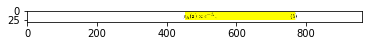

In [19]:
#model.save_weights('current_best2.h5')
plt.imshow(temp);plt.show()

In [62]:
model.load_weights('current_best2.h5')

In [25]:
filename = 'utils.py'
exec(compile(open(filename, "rb").read(), filename, 'exec'))
import time
import xml
OBJ_THRESHOLD    = 0.11
NMS_THRESHOLD    = 0.4
start_time = time.time()
doc = xml.dom.minidom.Document() 
#在内存中创建一个空的文档
offyy = 5
root = doc.createElement('root') 
def writeimage(imagename):
    singleimage = doc.createElement('document') 
    singleimage.setAttribute('filename', imagename) 
    return singleimage  
# generate the probs and coords for boxes
def write2xml(boxname,  prob, coord):


    nodeManager = doc.createElement(boxname)
    nodeManager.setAttribute('prob', prob)
    nodeName = doc.createElement('Coords')
    nodeName.setAttribute('points', coord)

    nodeManager.appendChild(nodeName)
    return nodeManager

for idx, img_name in enumerate(sorted(os.listdir(test_image_folder))):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    singleimage = writeimage(img_name)
    imagepath = os.path.join(test_image_folder,img_name)

    #plt.figure(figsize=(10,10))
    image = cv2.imread(imagepath)
    col_index = judge_image_col(image)
    if col_index!= 0:
        image_l = image[:,:col_index]/255.0
        image_r = image[:,col_index:]/255.0
    h,w,_ = image.shape
    
    
    input_image = cv2.resize(image, (IMAGE_H, IMAGE_W))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]

    
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict(input_image)
    boxes = decode_netout2(netout, 
                          obj_threshold=OBJ_THRESHOLD,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)    
    for box in boxes:
        x1, y1, x2, y2,new_probs  = box.xmin, box.ymin, box.xmax, box.ymax, box.c
        
        key = LABELS[box.get_label()]
        x1, y1, x2, y2 = int(round(x1*w)), int(round(y1*h)), int(round(x2*w)), int(round(y2*h))        
        if x1 < 10 or y1 < 10 or x2> w-10 or y2 > h - 10 or x2 - x1 < 10 or y2 - y1 < 10:
            continue         
                
            
        coord = str(x1)+','+str(y1)+' '+str(x2)+','+str(y1)+' '+ str(x1)+','+str(y2)+' '+ str(x2)+','+str(y2)
        
        nodeManager = write2xml( key, str(new_probs), coord)
        singleimage.appendChild(nodeManager)
 
    root.appendChild(singleimage)

doc.appendChild(root)
fp = open('Manager.xml', 'w')
doc.writexml(fp, indent='\t', addindent='\t', newl='\n', encoding="utf-8")
print(time.time() - start_time )

82.480872631073


In [26]:
fp.close()

In [20]:
fp.close()